In [204]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Implementacja warstw

In [205]:
class DenseLayer:
    def __init__(self, input_size, output_size):
        # self.weights = (
        #     np.random.rand(input_size, output_size) - 0.5
        # )  # TODO zamienić na inicjalizację z wykładu
        self.weights = np.random.uniform(-1/np.sqrt(11),1/np.sqrt(11), (input_size, output_size))
        self.bias = np.ones((1, output_size))

    def forward_pass(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_pass(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error


class ActivationLayer:
    def __init__(self) -> None:
        # self.activation = self.sigmoid
        # self.activation_prime = self.sigmoid_prime
        self.activation = self.sigmoid
        self.activation_prime = self.sigmoid_prime

    def forward_pass(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward_pass(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_prime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_prime(self, x):
        return 1 - np.tanh(x) ** 2

## Implementacja sztucznej sieci neuronowej

In [206]:
class ANN:
    def __init__(self):
        self.layers = []
        self.loss = self.mse
        self.loss_prime = self.mse_prime

    def mse(self, y, y_pred):
        return np.mean(np.power(y - y_pred, 2))

    def mse_prime(self, y, y_pred):
        return 2 * (y_pred - y) / y.size


    def fit(self, X_train, y_train, learning_rate, epochs_num, X_test, y_test):
        x_train_transformed = X_train.reshape(X_train.shape[0], 1, X_train.shape[1] )
        err_list = []
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(np.array(y_train).reshape(-1,1))
        y_train_transformed = enc.transform(np.array(y_train).reshape(-1,1)).toarray()
        x_test_transformed = X_test.reshape(X_test.shape[0], 1, X_test.shape[1] )
        for epoch_num in range(epochs_num):
            err = 0
            for i in range(len(x_train_transformed)):
                output = x_train_transformed[i]
                for layer in self.layers:
                    output = layer.forward_pass(output)

                err += self.loss(y_train_transformed[i], output)

                error = self.loss_prime(y_train_transformed[i], output)

                for layer in reversed(self.layers):
                    error = layer.backward_pass(error, learning_rate)
            err /= len(x_train_transformed)
            
            err_list.append(err)
            
            out = net.predict(x_test_transformed)
            train_out = net.predict(x_train_transformed)
            
            preds_arg = np.array([np.argmax(prediction) for prediction in out])
            preds = [list(enc.categories_)[0][pred] for pred in preds_arg]
            preds_arg_train = np.array([np.argmax(prediction) for prediction in train_out])
            preds_train = [list(enc.categories_)[0][pred] for pred in preds_arg_train]
            
            y_true = y_test.to_list()
            y_true_train = y_train.to_list()
            
            test_accuracy = accuracy_score(y_true, preds)
            train_accuracy = accuracy_score(y_true_train, preds_train)
            
            if (epoch_num+1)%25==0 or epoch_num==0:
                print("epoch %d/%d   error=%f    test accuracy: %f     train accuracy: %f" % (epoch_num + 1, epochs_num, err, test_accuracy, train_accuracy))

        return err_list

    def predict(self, X_train):
        result = []
        for x in X_train:
            output = x
            for layer in self.layers:
                output = layer.forward_pass(output)

            result.append(output)

        return result

    def add(self, layer):
        self.layers.append(layer)

    def set(self, shape):
        for idx in range(len(shape) - 1):
            self.add(DenseLayer(shape[idx], shape[idx + 1]))
            self.add(ActivationLayer())

## Import danych i ich podział na X i y

In [207]:
main_df = pd.read_csv('data/winequality-red.csv', sep=';')
y = main_df.quality
X = main_df.drop(columns=["quality"])

## Normalizacja danych oraz podzielenie na zbiór testowy i treningowy

In [208]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(y_train).reshape(-1,1))

(959, 11)
(640, 11)
(959,)
(640,)


OneHotEncoder(handle_unknown='ignore')

## Uczenie sieci

### Eksperyment 1

In [209]:
net = ANN()
net.set((11, 50, 6))
err_list = net.fit(X_train, y_train, epochs_num=500, learning_rate=0.1, X_test=X_test, y_test=y_test)

epoch 1/500   error=0.113971    test accuracy: 0.410938     train accuracy: 0.447341
epoch 25/500   error=0.087352    test accuracy: 0.570312     train accuracy: 0.603754
epoch 50/500   error=0.084662    test accuracy: 0.585938     train accuracy: 0.619395
epoch 75/500   error=0.082452    test accuracy: 0.589063     train accuracy: 0.638165
epoch 100/500   error=0.080294    test accuracy: 0.600000     train accuracy: 0.650678
epoch 125/500   error=0.078293    test accuracy: 0.596875     train accuracy: 0.656934
epoch 150/500   error=0.076013    test accuracy: 0.604688     train accuracy: 0.678832
epoch 175/500   error=0.073107    test accuracy: 0.609375     train accuracy: 0.696559
epoch 200/500   error=0.070094    test accuracy: 0.614062     train accuracy: 0.715328
epoch 225/500   error=0.067197    test accuracy: 0.615625     train accuracy: 0.725756
epoch 250/500   error=0.064373    test accuracy: 0.615625     train accuracy: 0.740355
epoch 275/500   error=0.061727    test accuracy:

In [210]:
out = net.predict(X_test)
train_out = net.predict(X_train)

In [211]:
preds_arg = np.array([np.argmax(prediction) for prediction in out])
preds = [list(enc.categories_)[0][pred] for pred in preds_arg]
preds_arg_train = np.array([np.argmax(prediction) for prediction in train_out])
preds_train = [list(enc.categories_)[0][pred] for pred in preds_arg_train]
y_true = y_test.to_list()
y_true_train = y_train.to_list()

Accuracy test: 0.6109375
Accuracy train: 0.8394160583941606


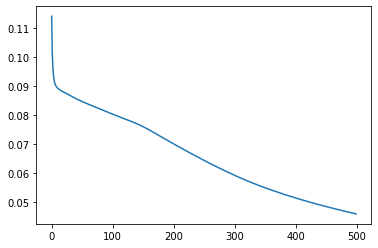

In [212]:
print('Accuracy test:', accuracy_score(y_true, preds))
print('Accuracy train:', accuracy_score(y_true_train, preds_train))
plt.plot(err_list);

### Eksperyment 2 - liczba epok: 500 , współczynnik uczenia = 0.4 ( duży )

In [213]:
net = ANN()
net.set((11, 50, 6))
err_list = net.fit(X_train, y_train, epochs_num=500, learning_rate=0.4, X_test=X_test, y_test=y_test)
out = net.predict(X_test)
train_out = net.predict(X_train)
preds_arg = np.array([np.argmax(prediction) for prediction in out])
preds = [list(enc.categories_)[0][pred] for pred in preds_arg]
preds_arg_train = np.array([np.argmax(prediction) for prediction in train_out])
preds_train = [list(enc.categories_)[0][pred] for pred in preds_arg_train]
y_true = y_test.to_list()
y_true_train = y_train.to_list()

epoch 1/500   error=0.106933    test accuracy: 0.562500     train accuracy: 0.578728
epoch 25/500   error=0.086051    test accuracy: 0.585938     train accuracy: 0.633994
epoch 50/500   error=0.077308    test accuracy: 0.600000     train accuracy: 0.689260
epoch 75/500   error=0.067830    test accuracy: 0.596875     train accuracy: 0.724713
epoch 100/500   error=0.058709    test accuracy: 0.564063     train accuracy: 0.749739
epoch 125/500   error=0.052284    test accuracy: 0.571875     train accuracy: 0.773723
epoch 150/500   error=0.046507    test accuracy: 0.571875     train accuracy: 0.801877
epoch 175/500   error=0.041740    test accuracy: 0.568750     train accuracy: 0.819604
epoch 200/500   error=0.037825    test accuracy: 0.575000     train accuracy: 0.826903
epoch 225/500   error=0.033896    test accuracy: 0.581250     train accuracy: 0.852972
epoch 250/500   error=0.030726    test accuracy: 0.584375     train accuracy: 0.866528
epoch 275/500   error=0.028264    test accuracy:

Accuracy test: 0.603125
Accuracy train: 0.9322210636079249


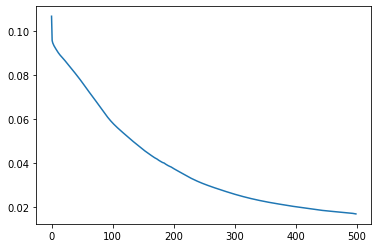

In [214]:
print('Accuracy test:', accuracy_score(y_true, preds))
print('Accuracy train:', accuracy_score(y_true_train, preds_train))
plt.plot(err_list);

### Eksperyment 3 - liczba epok: 500, współczynnik uczenia = 0.05 

In [215]:
net = ANN()
net.set((11, 50, 6))
err_list = net.fit(X_train, y_train, epochs_num=500, learning_rate=0.05, X_test=X_test, y_test=y_test);
out = net.predict(X_test)
train_out = net.predict(X_train)
preds_arg = np.array([np.argmax(prediction) for prediction in out])
preds = [list(enc.categories_)[0][pred] for pred in preds_arg]
preds_arg_train = np.array([np.argmax(prediction) for prediction in train_out])
preds_train = [list(enc.categories_)[0][pred] for pred in preds_arg_train]
y_true = y_test.to_list()
y_true_train = y_train.to_list()

epoch 1/500   error=0.120601    test accuracy: 0.387500     train accuracy: 0.406674
epoch 25/500   error=0.087744    test accuracy: 0.570312     train accuracy: 0.604797
epoch 50/500   error=0.086273    test accuracy: 0.579688     train accuracy: 0.607925
epoch 75/500   error=0.084942    test accuracy: 0.579688     train accuracy: 0.619395
epoch 100/500   error=0.083569    test accuracy: 0.581250     train accuracy: 0.623566
epoch 125/500   error=0.082301    test accuracy: 0.589063     train accuracy: 0.642336
epoch 150/500   error=0.081134    test accuracy: 0.584375     train accuracy: 0.645464
epoch 175/500   error=0.080005    test accuracy: 0.584375     train accuracy: 0.646507
epoch 200/500   error=0.078894    test accuracy: 0.589063     train accuracy: 0.657977
epoch 225/500   error=0.077821    test accuracy: 0.603125     train accuracy: 0.657977
epoch 250/500   error=0.076775    test accuracy: 0.607812     train accuracy: 0.661105
epoch 275/500   error=0.075729    test accuracy:

Accuracy test: 0.6046875
Accuracy train: 0.7559958289885297


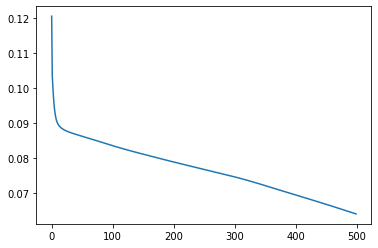

In [216]:
print('Accuracy test:', accuracy_score(y_true, preds))
print('Accuracy train:', accuracy_score(y_true_train, preds_train))
plt.plot(err_list);

### Eksperyment 4 - liczba epok: 2000, współczynnik uczenia = 0.05 

In [217]:
net = ANN()
net.set((11, 50, 6))
err_list = net.fit(X_train, y_train, epochs_num=2000, learning_rate=0.05, X_test=X_test, y_test=y_test)
out = net.predict(X_test)
train_out = net.predict(X_train)
preds_arg = np.array([np.argmax(prediction) for prediction in out])
preds = [list(enc.categories_)[0][pred] for pred in preds_arg]
preds_arg_train = np.array([np.argmax(prediction) for prediction in train_out])
preds_train = [list(enc.categories_)[0][pred] for pred in preds_arg_train]
y_true = y_test.to_list()
y_true_train = y_train.to_list()

epoch 1/2000   error=0.118841    test accuracy: 0.389062     train accuracy: 0.407716
epoch 25/2000   error=0.087552    test accuracy: 0.565625     train accuracy: 0.602711
epoch 50/2000   error=0.085825    test accuracy: 0.579688     train accuracy: 0.607925
epoch 75/2000   error=0.084455    test accuracy: 0.579688     train accuracy: 0.618352
epoch 100/2000   error=0.083210    test accuracy: 0.589063     train accuracy: 0.630865
epoch 125/2000   error=0.081964    test accuracy: 0.592187     train accuracy: 0.641293
epoch 150/2000   error=0.080664    test accuracy: 0.592187     train accuracy: 0.644421
epoch 175/2000   error=0.079389    test accuracy: 0.595313     train accuracy: 0.655892
epoch 200/2000   error=0.078145    test accuracy: 0.601562     train accuracy: 0.662148
epoch 225/2000   error=0.076865    test accuracy: 0.612500     train accuracy: 0.669447
epoch 250/2000   error=0.075526    test accuracy: 0.620313     train accuracy: 0.674661
epoch 275/2000   error=0.074146    te

Accuracy test: 0.6046875
Accuracy train: 0.935349322210636


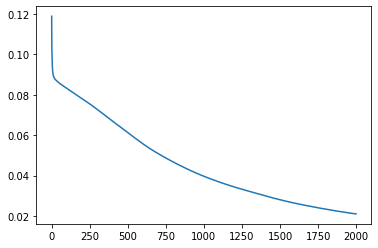

In [219]:
print('Accuracy test:', accuracy_score(y_true, preds))
print('Accuracy train:', accuracy_score(y_true_train, preds_train))
plt.plot(err_list);

### Eksperyment 5 - liczba epok: 2000, współczynnik uczenia = 0.05 

In [220]:
net = ANN()
net.set((11, 100, 6))
err_list = net.fit(X_train, y_train, epochs_num=2000, learning_rate=0.05, X_test=X_test, y_test=y_test)
out = net.predict(X_test)
train_out = net.predict(X_train)
preds_arg = np.array([np.argmax(prediction) for prediction in out])
preds = [list(enc.categories_)[0][pred] for pred in preds_arg]
preds_arg_train = np.array([np.argmax(prediction) for prediction in train_out])
preds_train = [list(enc.categories_)[0][pred] for pred in preds_arg_train]
y_true = y_test.to_list()
y_true_train = y_train.to_list()

epoch 1/2000   error=0.110629    test accuracy: 0.446875     train accuracy: 0.470282
epoch 25/2000   error=0.088089    test accuracy: 0.565625     train accuracy: 0.596455
epoch 50/2000   error=0.086473    test accuracy: 0.579688     train accuracy: 0.601668
epoch 75/2000   error=0.085091    test accuracy: 0.582812     train accuracy: 0.615224
epoch 100/2000   error=0.083960    test accuracy: 0.587500     train accuracy: 0.620438
epoch 125/2000   error=0.082905    test accuracy: 0.596875     train accuracy: 0.632951
epoch 150/2000   error=0.081790    test accuracy: 0.598437     train accuracy: 0.640250
epoch 175/2000   error=0.080637    test accuracy: 0.606250     train accuracy: 0.648592
epoch 200/2000   error=0.079489    test accuracy: 0.600000     train accuracy: 0.661105
epoch 225/2000   error=0.078342    test accuracy: 0.606250     train accuracy: 0.665276
epoch 250/2000   error=0.077131    test accuracy: 0.603125     train accuracy: 0.675704
epoch 275/2000   error=0.075826    te

Accuracy test: 0.5828125
Accuracy train: 0.9457768508863399


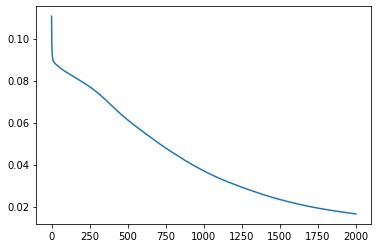

In [221]:
print('Accuracy test:', accuracy_score(y_true, preds))
print('Accuracy train:', accuracy_score(y_true_train, preds_train))
plt.plot(err_list);

### Eksperyment 6 - liczba epok: 2000, współczynnik uczenia = 0.05 

In [222]:
net = ANN()
net.set((11, 1000, 6))
err_list = net.fit(X_train, y_train, epochs_num=2000, learning_rate=0.05, X_test=X_test, y_test=y_test)
out = net.predict(X_test)
train_out = net.predict(X_train)
preds_arg = np.array([np.argmax(prediction) for prediction in out])
preds = [list(enc.categories_)[0][pred] for pred in preds_arg]
preds_arg_train = np.array([np.argmax(prediction) for prediction in train_out])
preds_train = [list(enc.categories_)[0][pred] for pred in preds_arg_train]
y_true = y_test.to_list()
y_true_train = y_train.to_list()

epoch 1/2000   error=0.137142    test accuracy: 0.556250     train accuracy: 0.568300
epoch 25/2000   error=0.102368    test accuracy: 0.562500     train accuracy: 0.596455
epoch 50/2000   error=0.099785    test accuracy: 0.582812     train accuracy: 0.602711
epoch 75/2000   error=0.097400    test accuracy: 0.579688     train accuracy: 0.599583
epoch 100/2000   error=0.095500    test accuracy: 0.592187     train accuracy: 0.613139
epoch 125/2000   error=0.094139    test accuracy: 0.590625     train accuracy: 0.623566
epoch 150/2000   error=0.092921    test accuracy: 0.590625     train accuracy: 0.627737
epoch 175/2000   error=0.091642    test accuracy: 0.595313     train accuracy: 0.632951
epoch 200/2000   error=0.090290    test accuracy: 0.593750     train accuracy: 0.635036
epoch 225/2000   error=0.088816    test accuracy: 0.593750     train accuracy: 0.631908
epoch 250/2000   error=0.087294    test accuracy: 0.600000     train accuracy: 0.638165
epoch 275/2000   error=0.085842    te

Accuracy test: 0.571875
Accuracy train: 0.8967674661105318


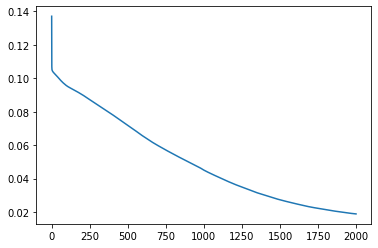

In [223]:
print('Accuracy test:', accuracy_score(y_true, preds))
print('Accuracy train:', accuracy_score(y_true_train, preds_train))
plt.plot(err_list);